### **Sentiment Analysis of Customer Reviewson a restaurantusing Deep Recurrent Neural NetworkLearning Techniques**

DS - 2 Project by Group 5

In [1]:
import numpy as np
import pandas as pd
import timeit
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from textblob import Word
from collections import Counter
nltk.download('wordnet')
nltk.download('omw-1.4')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import tensorflow as tf
from tensorflow import keras
import random

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [5]:
from google.colab import files
uploaded = files.upload()

Saving Founding Farmers_Consolidated.csv to Founding Farmers_Consolidated.csv


In [6]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Founding Farmers_Consolidated.csv']))

# Analysing the raw data got from web scraping

In [7]:
df.head()

,S/N,Reviews
0,1,Knowing this restaurant does not have Gluten F...
1,2,Food was great but appetizers arrived right be...
2,3,We did an early dinner and the service was sup...
3,4,The worst and cheapest meat cut I have ever ta...
4,5,It was such a great experience! Enjoyed visiti...


In [9]:
# total number of reviews
len(df['Reviews'])

23458

In [10]:
# Checking the number of words in each reviews
df['word_count'] = df['Reviews'].apply(lambda x: len(x.split()))

In [11]:
df.head()

,S/N,Reviews,word_count
0,1,Knowing this restaurant does not have Gluten F...,159
1,2,Food was great but appetizers arrived right be...,9
2,3,We did an early dinner and the service was sup...,21
3,4,The worst and cheapest meat cut I have ever ta...,47
4,5,It was such a great experience! Enjoyed visiti...,15


In [12]:
# Checking the number of characters in each reviews
df['char_count'] = df['Reviews'].apply(lambda x: len(x))

In [13]:
# Creating a function to find the average number of words in a review
def avg_word(review):
    words = review.split()
    return (sum(len(word) for word in words) / len(words))

In [14]:
df['avg_word'] = df['Reviews'].apply(lambda x: avg_word(x))

In [15]:
# Import stopwords
from nltk.corpus import stopwords
# remove stopwords
# pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
# has been programmed to ignore, both when indexing entries for searching and when retrieving them 
# as the result of a search query.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
stop_words = set(stopwords.words("english"))

In [17]:
df['stopword_coun'] = df['Reviews'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

In [18]:
df['stopword_rate'] = df['stopword_coun']/df['word_count']

In [19]:
df.head()

,S/N,Reviews,word_count,char_count,avg_word,stopword_coun,stopword_rate
0,1,Knowing this restaurant does not have Gluten F...,159,848,4.339623,70,0.440252
1,2,Food was great but appetizers arrived right be...,9,58,5.555556,3,0.333333
2,3,We did an early dinner and the service was sup...,21,126,5.047619,9,0.428571
3,4,The worst and cheapest meat cut I have ever ta...,47,242,4.170213,20,0.425532
4,5,It was such a great experience! Enjoyed visiti...,15,93,5.266667,7,0.466667


In [20]:
df.describe()

,S/N,word_count,char_count,avg_word,stopword_coun,stopword_rate
count,23458.000000,23458.000000,23458.000000,23458.000000,23458.000000,23458.000000
mean,11729.500000,45.744394,254.365803,4.818948,18.654532,0.360792
std,6771.885643,49.581324,269.410989,1.255625,22.081367,0.117794
min,1.000000,1.000000,6.000000,1.452381,0.000000,0.000000
25%,5865.250000,14.000000,82.000000,4.336431,5.000000,0.312500
50%,11729.500000,29.000000,164.000000,4.642857,11.000000,0.384615
75%,17593.750000,59.000000,325.000000,5.062500,24.000000,0.438017
max,23458.000000,403.000000,2000.000000,90.000000,208.000000,0.777778


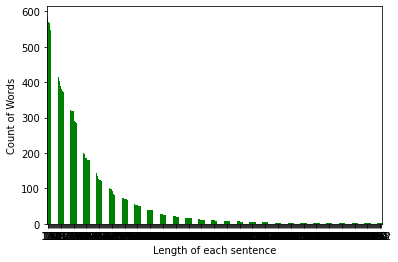

In [21]:
import matplotlib.pyplot as plt

Sentiment_count=df.groupby('word_count').count()
positions = (1,15)
df['word_count'].value_counts().plot(kind='bar',color='Green')
plt.xlabel('Length of each sentence')
plt.ylabel('Count of Words')
plt.xticks(rotation =0)
plt.show()


# Removing the Outliers

In [22]:
df = df[(df.word_count < 100)]
df.shape

(20923, 7)

In [23]:
# Removing the rows with more stop words.
df = df[(df.stopword_coun < 30)]
df.shape

(18873, 7)

# Cleaning the data

In [24]:
# Lower case all words
df['review_lower'] = df['Reviews'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [25]:
# Remove Punctuation
df['review_nopunc'] = df['review_lower'].str.replace('[^\w\s]', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [26]:
# Remove Stopwords since they add no sentiment meaning to the sentence
df['review_nopunc_nostop'] = df['review_nopunc'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [27]:
# Return frequency of the words used
freq= pd.Series(" ".join(df['review_nopunc_nostop']).split()).value_counts()[:50]
freq

food           11342
great           7428
service         6209
good            4783
time            2802
brunch          2406
excellent       2182
delicious       2027
restaurant      1947
back            1853
reservation     1844
server          1804
farmers         1786
place           1779
experience      1752
founding        1743
amazing         1692
always          1684
wait            1593
menu            1506
would           1461
us              1434
table           1374
go              1245
chicken         1205
definitely      1156
drinks          1153
meal            1097
staff           1097
one             1086
dc              1067
seated          1060
really          1051
get             1042
everything      1033
nice            1023
dinner          1022
made            1014
waiter          1010
recommend       1003
best             983
love             976
minutes          943
like             920
wonderful        910
well             906
even             889
buffet       

In [28]:
# Removing other redundant words from the reviews which doesn't contribute to the sentiment analysis.
other_stopwords = ['get', 'us', 'see', 'use', 'said', 'asked', 'day', 'go','even', 'ive', 'right', 'left', 'always', 'would', 'told','one', 'also', 'ever', 'dc', 'take', 'let','back','took']

In [29]:
df['review_nopunc_nostop_nocommon'] = df['review_nopunc_nostop'].apply(lambda x: "".join(" ".join(x for x in x.split() if x not in other_stopwords)))

In [30]:
df.describe()

,S/N,word_count,char_count,avg_word,stopword_coun,stopword_rate
count,18873.000000,18873.000000,18873.000000,18873.000000,18873.00000,18873.000000
mean,11829.766386,26.675833,151.379378,4.908846,10.10417,0.342797
std,6851.730009,18.171057,101.181747,1.378398,7.78187,0.122904
min,2.000000,1.000000,6.000000,1.452381,0.00000,0.000000
25%,5732.000000,12.000000,70.000000,4.379310,4.00000,0.285714
50%,12141.000000,22.000000,127.000000,4.733333,8.00000,0.363636
75%,17701.000000,38.000000,216.000000,5.200000,15.00000,0.424242
max,23457.000000,97.000000,607.000000,90.000000,29.00000,0.777778


# Lemmatization

In [31]:
# Lemmatize final review format
df['cleaned_review'] = df['review_nopunc_nostop_nocommon'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [32]:
df.head()

,S/N,Reviews,word_count,char_count,avg_word,stopword_coun,stopword_rate,review_lower,review_nopunc,review_nopunc_nostop,review_nopunc_nostop_nocommon,cleaned_review
1,2,Food was great but appetizers arrived right be...,9,58,5.555556,3,0.333333,food was great but appetizers arrived right be...,food was great but appetizers arrived right be...,food great appetizers arrived right entrees,food great appetizers arrived entrees,food great appetizer arrived entree
2,3,We did an early dinner and the service was sup...,21,126,5.047619,9,0.428571,we did an early dinner and the service was sup...,we did an early dinner and the service was sup...,early dinner service superb especially accommo...,early dinner service superb especially accommo...,early dinner service superb especially accommo...
3,4,The worst and cheapest meat cut I have ever ta...,47,242,4.170213,20,0.425532,the worst and cheapest meat cut i have ever ta...,the worst and cheapest meat cut i have ever ta...,worst cheapest meat cut ever tasted two five e...,worst cheapest meat cut tasted two five entrée...,worst cheapest meat cut tasted two five entrée...
4,5,It was such a great experience! Enjoyed visiti...,15,93,5.266667,7,0.466667,it was such a great experience! enjoyed visiti...,it was such a great experience enjoyed visitin...,great experience enjoyed visiting friends food...,great experience enjoyed visiting friends food...,great experience enjoyed visiting friend food ...
5,6,I asked for a quieter table and that’s what we...,51,269,4.294118,23,0.450980,i asked for a quieter table and that’s what we...,i asked for a quieter table and thats what we ...,asked quieter table thats given food always go...,quieter table thats given food good waiter obv...,quieter table thats given food good waiter obv...


# SentimenT Analysis

In [33]:
from textblob import TextBlob
df['polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment[1])

In [34]:
df.head()

,S/N,Reviews,word_count,char_count,avg_word,stopword_coun,stopword_rate,review_lower,review_nopunc,review_nopunc_nostop,review_nopunc_nostop_nocommon,cleaned_review,polarity,subjectivity
1,2,Food was great but appetizers arrived right be...,9,58,5.555556,3,0.333333,food was great but appetizers arrived right be...,food was great but appetizers arrived right be...,food great appetizers arrived right entrees,food great appetizers arrived entrees,food great appetizer arrived entree,0.800000,0.750000
2,3,We did an early dinner and the service was sup...,21,126,5.047619,9,0.428571,we did an early dinner and the service was sup...,we did an early dinner and the service was sup...,early dinner service superb especially accommo...,early dinner service superb especially accommo...,early dinner service superb especially accommo...,0.275000,0.700000
3,4,The worst and cheapest meat cut I have ever ta...,47,242,4.170213,20,0.425532,the worst and cheapest meat cut i have ever ta...,the worst and cheapest meat cut i have ever ta...,worst cheapest meat cut ever tasted two five e...,worst cheapest meat cut tasted two five entrée...,worst cheapest meat cut tasted two five entrée...,-0.433333,0.488889
4,5,It was such a great experience! Enjoyed visiti...,15,93,5.266667,7,0.466667,it was such a great experience! enjoyed visiti...,it was such a great experience enjoyed visitin...,great experience enjoyed visiting friends food...,great experience enjoyed visiting friends food...,great experience enjoyed visiting friend food ...,0.655556,0.816667
5,6,I asked for a quieter table and that’s what we...,51,269,4.294118,23,0.450980,i asked for a quieter table and that’s what we...,i asked for a quieter table and thats what we ...,asked quieter table thats given food always go...,quieter table thats given food good waiter obv...,quieter table thats given food good waiter obv...,0.468750,0.587500


In [35]:
df.drop(['review_lower','review_nopunc','review_nopunc_nostop','review_nopunc_nostop_nocommon'],axis=1, inplace = True)

In [36]:
# Rounding up all the decimal points to two decimals.
df['polarity'] = df['polarity'].round(decimals = 2)
df['subjectivity'] = df['subjectivity'].round(decimals = 2)
df['stopword_rate'] = df['stopword_rate'].round(decimals = 2)
df['avg_word'] = df['avg_word'].round(decimals = 2)

In [37]:
df['polarity'] = df['polarity']*100
df['subjectivity'] = df['subjectivity']*100

In [38]:
df.head()

,S/N,Reviews,word_count,char_count,avg_word,stopword_coun,stopword_rate,cleaned_review,polarity,subjectivity
1,2,Food was great but appetizers arrived right be...,9,58,5.56,3,0.33,food great appetizer arrived entree,80.0,75.0
2,3,We did an early dinner and the service was sup...,21,126,5.05,9,0.43,early dinner service superb especially accommo...,28.0,70.0
3,4,The worst and cheapest meat cut I have ever ta...,47,242,4.17,20,0.43,worst cheapest meat cut tasted two five entrée...,-43.0,49.0
4,5,It was such a great experience! Enjoyed visiti...,15,93,5.27,7,0.47,great experience enjoyed visiting friend food ...,66.0,82.0
5,6,I asked for a quieter table and that’s what we...,51,269,4.29,23,0.45,quieter table thats given food good waiter obv...,47.0,59.0


In [39]:
df.describe()

,S/N,word_count,char_count,avg_word,stopword_coun,stopword_rate,polarity,subjectivity
count,18873.000000,18873.000000,18873.000000,18873.000000,18873.00000,18873.000000,18873.000000,18873.000000
mean,11829.766386,26.675833,151.379378,4.908859,10.10417,0.342504,37.309808,63.564298
std,6851.730009,18.171057,101.181747,1.378404,7.78187,0.122968,32.927222,21.167686
min,2.000000,1.000000,6.000000,1.450000,0.00000,0.000000,-100.000000,0.000000
25%,5732.000000,12.000000,70.000000,4.380000,4.00000,0.290000,17.000000,53.000000
50%,12141.000000,22.000000,127.000000,4.730000,8.00000,0.360000,40.000000,65.000000
75%,17701.000000,38.000000,216.000000,5.200000,15.00000,0.420000,60.000000,76.000000
max,23457.000000,97.000000,607.000000,90.000000,29.00000,0.780000,100.000000,100.000000


In [40]:
df['polarity']=df['polarity'].astype(np.int64)

In [41]:
# Function for converting the polarity into three labels 
def analysis(polarity):
    if polarity >= 40:
        return 1
    elif polarity > 0 and polarity < 40:
        return 0
    else:
        return -1

In [42]:
df['Sentiment_Label'] = df['polarity'].apply(lambda x: analysis(x))

In [43]:
df.head()

,S/N,Reviews,word_count,char_count,avg_word,stopword_coun,stopword_rate,cleaned_review,polarity,subjectivity,Sentiment_Label
1,2,Food was great but appetizers arrived right be...,9,58,5.56,3,0.33,food great appetizer arrived entree,80,75.0,1
2,3,We did an early dinner and the service was sup...,21,126,5.05,9,0.43,early dinner service superb especially accommo...,28,70.0,0
3,4,The worst and cheapest meat cut I have ever ta...,47,242,4.17,20,0.43,worst cheapest meat cut tasted two five entrée...,-43,49.0,-1
4,5,It was such a great experience! Enjoyed visiti...,15,93,5.27,7,0.47,great experience enjoyed visiting friend food ...,66,82.0,1
5,6,I asked for a quieter table and that’s what we...,51,269,4.29,23,0.45,quieter table thats given food good waiter obv...,47,59.0,1


In [44]:
df.drop(['word_count','char_count','stopword_coun','stopword_rate','Reviews','subjectivity','avg_word','polarity'],axis=1, inplace = True)

In [45]:
df.head()

,S/N,cleaned_review,Sentiment_Label
1,2,food great appetizer arrived entree,1
2,3,early dinner service superb especially accommo...,0
3,4,worst cheapest meat cut tasted two five entrée...,-1
4,5,great experience enjoyed visiting friend food ...,1
5,6,quieter table thats given food good waiter obv...,1


In [46]:
#Check if there are any null values
data_v1 = df[['cleaned_review','Sentiment_Label']]
data_v1.isnull().sum()

cleaned_review     0
Sentiment_Label    0
dtype: int64

In [48]:
df.head()

,S/N,cleaned_review,Sentiment_Label
1,2,food great appetizer arrived entree,1
2,3,early dinner service superb especially accommo...,0
3,4,worst cheapest meat cut tasted two five entrée...,-1
4,5,great experience enjoyed visiting friend food ...,1
5,6,quieter table thats given food good waiter obv...,1


# Padding, Truncating, and Splitting

In [49]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned_review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11567 unique tokens.


In [50]:
X = tokenizer.texts_to_sequences(df['cleaned_review'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (18873, 100)


In [51]:
Y = pd.get_dummies(df['Sentiment_Label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (18873, 3)


In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16985, 100) (16985, 3)
(1888, 100) (1888, 3)


### Model Fitting

### **LSTM Model - 1**

In [53]:
# LSTM Model -1 creation
# Initialising the RNN
model1 = Sequential()
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(SpatialDropout1D(0.4))

#first LSTM layer
model1.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))


# Adding the output layer
# For Full connection layer we use dense
# As the output is multiclass so we use unit=3
#activation is softmax 
model1.add(Dense(3, activation='softmax'))

print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None


Model Architecture for Model -1

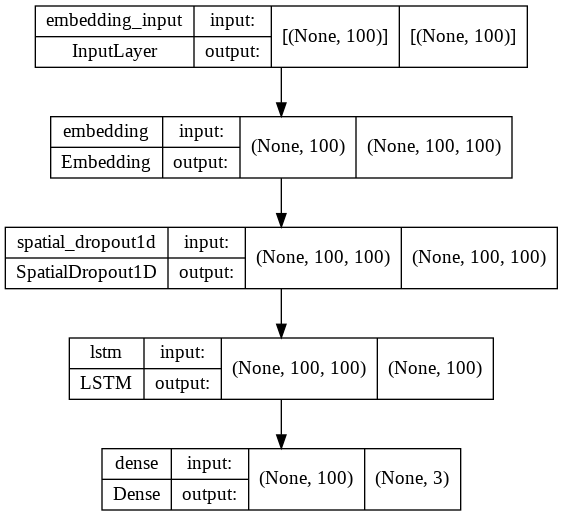

In [54]:
# Visualizing the Model Architecture
from keras.utils.vis_utils import plot_model
plot_model(model1,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [55]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training for Model -1

In [56]:
# Training the Model - 1
epochs = 5
batch_size = 64
trained_model1 = model1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
239/239 [==============================] - 88s 353ms/step - loss: 0.6721 - accuracy: 0.6953 - val_loss: 0.4283 - val_accuracy: 0.8140
Epoch 2/5
239/239 [==============================] - 85s 356ms/step - loss: 0.3487 - accuracy: 0.8569 - val_loss: 0.3549 - val_accuracy: 0.8387
Epoch 3/5
239/239 [==============================] - 83s 348ms/step - loss: 0.2461 - accuracy: 0.9046 - val_loss: 0.3292 - val_accuracy: 0.8652
Epoch 4/5
239/239 [==============================] - 83s 347ms/step - loss: 0.1911 - accuracy: 0.9274 - val_loss: 0.3127 - val_accuracy: 0.8829
Epoch 5/5
239/239 [==============================] - 83s 346ms/step - loss: 0.1691 - accuracy: 0.9366 - val_loss: 0.3325 - val_accuracy: 0.8746


Testing Accuracy for Model -1

In [57]:
test_loss, test_acc = model1.evaluate(X_test,Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

59/59 - 2s - loss: 0.3070 - accuracy: 0.8861 - 2s/epoch - 35ms/step

Test accuracy: 0.8861228823661804


Confusion Matrix for Model -1

In [58]:
y_test_arg1=np.argmax(Y_test,axis=1)
Y_pred1 = np.argmax(model1.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(Y_pred1,y_test_arg1))

Confusion Matrix
[[234  31   4]
 [ 45 536  62]
 [  0  73 903]]


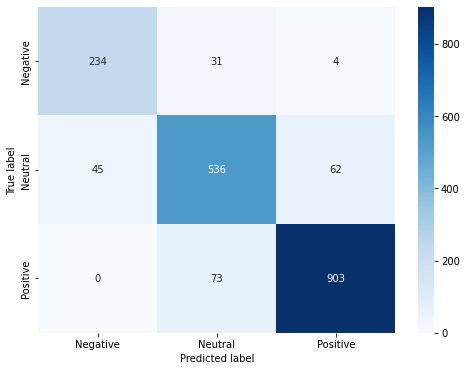

In [59]:
import seaborn as sns
y_test_arg1=np.argmax(Y_test,axis=1)
Y_pred1 = np.argmax(model1.predict(X_test),axis=1)
cm =confusion_matrix(Y_pred1,y_test_arg1)
cm_df = pd.DataFrame(cm,index = ['Negative','Neutral','Positive'],columns = ['Negative','Neutral','Positive'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='g',cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

F1 Score for Model -1

In [60]:
# The formula for the standard F1-score is the harmonic mean of the precision and recall. A perfect model has an F-score of 1.
from sklearn.metrics import f1_score
print('F1-score: {0}'.format(f1_score(Y_pred1,y_test_arg1,average='weighted')))

F1-score: 0.8862463511765408


Accuracy and loss for training and testing for Model -1

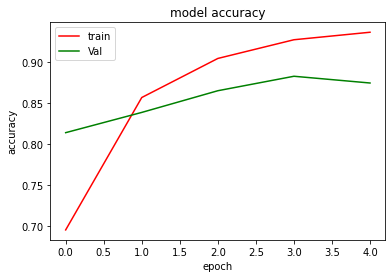

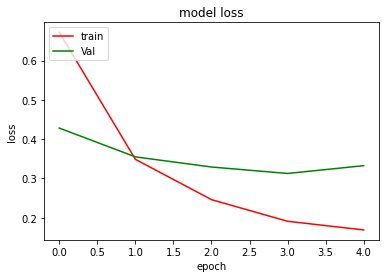

In [61]:
import matplotlib.pyplot as plt
plt.plot(trained_model1.history['accuracy'],color='red')
plt.plot(trained_model1.history['val_accuracy'],color='green')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','Val'], loc='upper left')
plt.show()

plt.plot(trained_model1.history['loss'],color='red')
plt.plot(trained_model1.history['val_loss'],color='green')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Val'], loc='upper left')
plt.show()

### **(GRU) Model - 2**

In [62]:
from keras.layers import GRU

In [67]:
# # Initialising the GRU model
model2 = Sequential()
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])
model2.add(embedding_layer)
model2.add(SpatialDropout1D(0.4))

#first GRU layer
model2.add(GRU(100, dropout=0.4, recurrent_dropout=0.4))


# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
#activation is sigmoid 
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5,060,903
Trainable params: 5,060,903
Non-trainable params: 0
_________________________________________________________________


Model Architecture for Model - 2

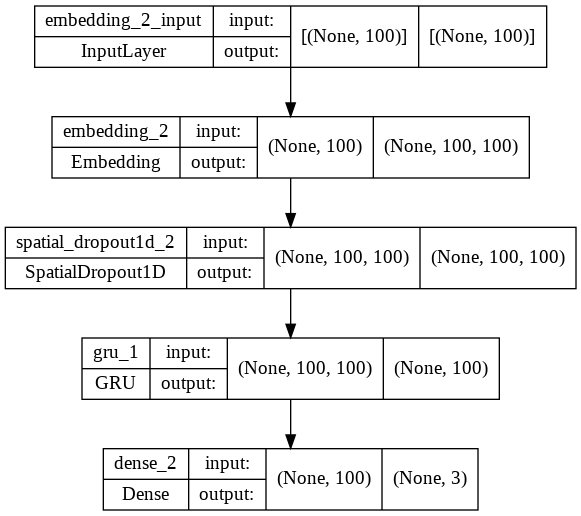

In [68]:
# Visualizing the Model Architecture
from keras.utils.vis_utils import plot_model
plot_model(model2,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [69]:
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Training for Model - 2

In [70]:
# Training the Model - 2
epochs = 5
batch_size = 64
trained_model2 = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
239/239 [==============================] - 87s 352ms/step - loss: 0.6533 - accuracy: 0.6934 - val_loss: 0.4111 - val_accuracy: 0.8234
Epoch 2/5
239/239 [==============================] - 75s 315ms/step - loss: 0.3376 - accuracy: 0.8563 - val_loss: 0.3297 - val_accuracy: 0.8523
Epoch 3/5
239/239 [==============================] - 75s 314ms/step - loss: 0.2552 - accuracy: 0.8976 - val_loss: 0.3123 - val_accuracy: 0.8699
Epoch 4/5
239/239 [==============================] - 75s 313ms/step - loss: 0.2035 - accuracy: 0.9192 - val_loss: 0.3342 - val_accuracy: 0.8664
Epoch 5/5
239/239 [==============================] - 75s 313ms/step - loss: 0.1789 - accuracy: 0.9305 - val_loss: 0.3294 - val_accuracy: 0.8735


Testing Accuracy for Model -2

In [71]:
test_loss, test_acc = model2.evaluate(X_test,Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

59/59 - 2s - loss: 0.3151 - accuracy: 0.8776 - 2s/epoch - 31ms/step

Test accuracy: 0.8776482939720154


Confusion Matrix for Model -2

In [72]:
y_test_arg2=np.argmax(Y_test,axis=1)
Y_pred2 = np.argmax(model2.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(Y_pred2,y_test_arg2))

Confusion Matrix
[[240  45   3]
 [ 32 509  58]
 [  7  86 908]]


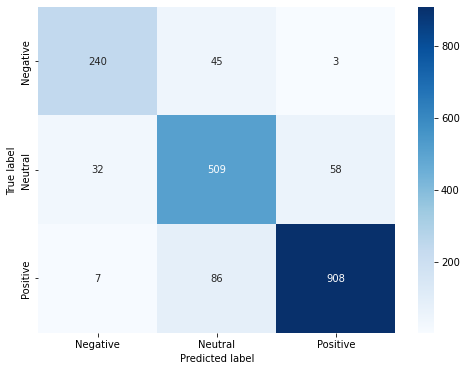

In [73]:
import seaborn as sns
y_test_arg2=np.argmax(Y_test,axis=1)
Y_pred2 = np.argmax(model2.predict(X_test),axis=1)
cm =confusion_matrix(Y_pred2,y_test_arg2)
cm_df = pd.DataFrame(cm,index = ['Negative','Neutral','Positive'],columns = ['Negative','Neutral','Positive'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='g',cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

F1 Score for Model -2

In [74]:
# The formula for the standard F1-score is the harmonic mean of the precision and recall. A perfect model has an F-score of 1.
from sklearn.metrics import f1_score
print('F1-score: {0}'.format(f1_score(Y_pred2,y_test_arg2,average='weighted')))

F1-score: 0.8785568539584724


Accuracy and loss for training and testing for Model -2

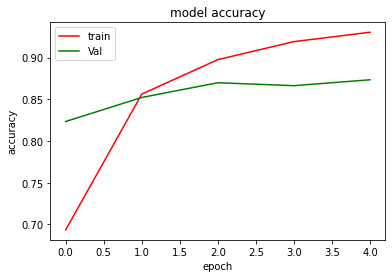

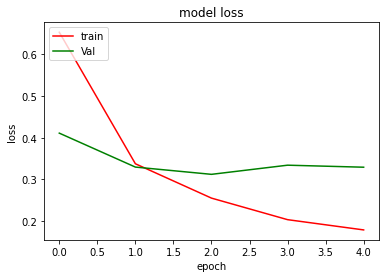

In [75]:
import matplotlib.pyplot as plt
plt.plot(trained_model2.history['accuracy'],color='red')
plt.plot(trained_model2.history['val_accuracy'],color='green')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','Val'], loc='upper left')
plt.show()

plt.plot(trained_model2.history['loss'],color='red')
plt.plot(trained_model2.history['val_loss'],color='green')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Val'], loc='upper left')
plt.show()

### **(CNN-LSTM HYBRID) Model - 3**

In [76]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models
from keras.layers import LSTM, Conv1D, Dense, Flatten, MaxPooling1D, Dropout
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [77]:
# CNN-LSTM HYBRID Model -3 creation
# Initialising the RNN
model3 = Sequential()
model3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model3.add(SpatialDropout1D(0.4))
#first CNN layer
model3.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
#max pooling layer
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.4))
#first LSTM layer
model3.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))


# Adding the output layer
# For Full connection layer we use dense
# As the output is multiclass so we use unit=3
#activation is softmax 
model3.add(Dense(3, activation='softmax'))

print(model3.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          5000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)              

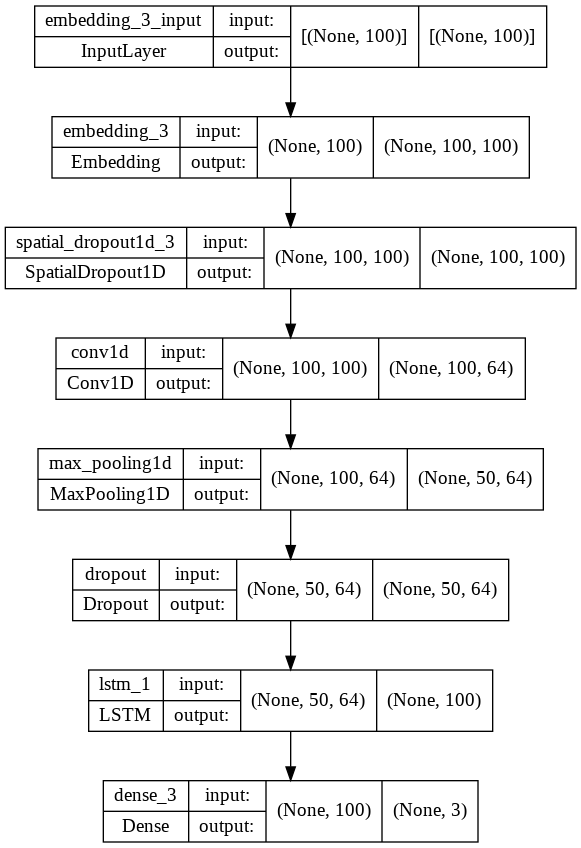

In [78]:
# Visualizing the Model Architecture
from keras.utils.vis_utils import plot_model
plot_model(model3,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

In [79]:
model3.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [80]:
# Training the Model - 3
epochs = 5
batch_size = 64
trained_model3= model3.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
239/239 [==============================] - 59s 232ms/step - loss: 0.6524 - accuracy: 0.7065 - val_loss: 0.3873 - val_accuracy: 0.8323
Epoch 2/5
239/239 [==============================] - 55s 229ms/step - loss: 0.3183 - accuracy: 0.8712 - val_loss: 0.3262 - val_accuracy: 0.8640
Epoch 3/5
239/239 [==============================] - 63s 264ms/step - loss: 0.2059 - accuracy: 0.9229 - val_loss: 0.3260 - val_accuracy: 0.8705
Epoch 4/5
239/239 [==============================] - 56s 235ms/step - loss: 0.1589 - accuracy: 0.9377 - val_loss: 0.3247 - val_accuracy: 0.8776
Epoch 5/5
239/239 [==============================] - 56s 232ms/step - loss: 0.1217 - accuracy: 0.9549 - val_loss: 0.3486 - val_accuracy: 0.8811


In [81]:
test_loss, test_acc = model3.evaluate(X_test,Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

59/59 - 2s - loss: 0.3479 - accuracy: 0.8814 - 2s/epoch - 40ms/step

Test accuracy: 0.8813559412956238


In [82]:
y_test_arg3=np.argmax(Y_test,axis=1)
Y_pred3 = np.argmax(model3.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(Y_pred3,y_test_arg3))

Confusion Matrix
[[249  43   2]
 [ 25 538  90]
 [  5  59 877]]


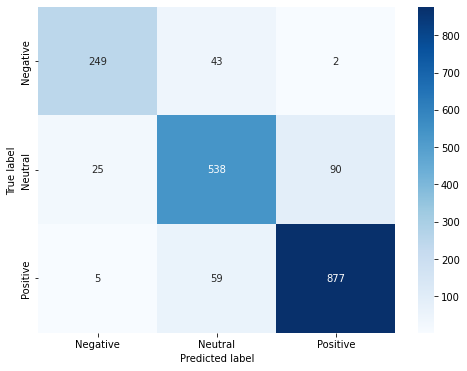

In [83]:
import seaborn as sns
y_test_arg3=np.argmax(Y_test,axis=1)
Y_pred3 = np.argmax(model3.predict(X_test),axis=1)
cm =confusion_matrix(Y_pred3,y_test_arg3)
cm_df = pd.DataFrame(cm,index = ['Negative','Neutral','Positive'],columns = ['Negative','Neutral','Positive'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='g',cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [84]:
# The formula for the standard F1-score is the harmonic mean of the precision and recall. A perfect model has an F-score of 1.
from sklearn.metrics import f1_score
print('F1-score: {0}'.format(f1_score(Y_pred3,y_test_arg3,average='weighted')))

F1-score: 0.8808638274195606


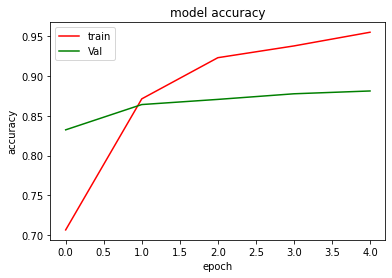

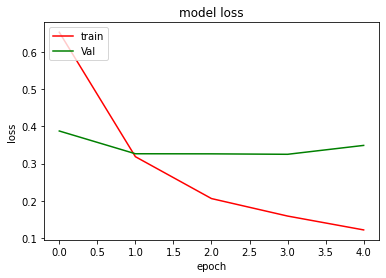

In [85]:
import matplotlib.pyplot as plt
plt.plot(trained_model3.history['accuracy'],color='red')
plt.plot(trained_model3.history['val_accuracy'],color='green')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','Val'], loc='upper left')
plt.show()

plt.plot(trained_model3.history['loss'],color='red')
plt.plot(trained_model3.history['val_loss'],color='green')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Val'], loc='upper left')
plt.show()

### **Testing it with User Inputs**

All our models are performing well. There isn't much difference between them. By considering the difference between the Training and Validation Accuracy we select both GRU and LSTM model for predicting with user inputs.


In [86]:
# MODEL 1 PERFORMANCE ON USER INPUT (LSTM) - Predicting a Positive review
new_review = ['I love this place. Wondeful service and amazing staff']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model1.predict(padded)
labels = [-1,0,1]
print(pred, labels[np.argmax(pred)])

[[1.2501747e-04 4.3478351e-02 9.5639658e-01]] 1


In [87]:
# MODEL 1 PERFORMANCE ON USER INPUT (LSTM) - Predicting a Negative review
new_review = ['I hate this place. Worst service and staff!']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model1.predict(padded)
labels = [-1,0,1]
print(pred, labels[np.argmax(pred)])

[[9.991596e-01 8.385537e-04 1.960637e-06]] -1


In [88]:
# MODEL 1 PERFORMANCE ON USER INPUT (LSTM) - Predicting a Neutral review
new_review = ['The food was okay. The place was loud too.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model1.predict(padded)
labels = [-1,0,1]
print(pred, labels[np.argmax(pred)])

[[0.00663906 0.58394873 0.40941224]] 0


In [92]:
# MODEL 2 PERFORMANCE ON USER INPUT (GRU) - Predicting a Positive review
new_review = ['Amazing, just amazing. Great portions, great service, large number of options to choose from (including desserts), ample seating, restroom and option for self or table service definitely worth it.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model2.predict(padded)
labels = [-1,0,1]
print(pred, labels[np.argmax(pred)])

[[1.3964626e-07 4.0746145e-02 9.5925379e-01]] 1


In [91]:
# MODEL 2 PERFORMANCE ON USER INPUT (GRU) - Predicting a Negative review
new_review = ['The food was cold. It could have been better. Not worth the time and money!!! What a waste:/']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model2.predict(padded)
labels = [-1,0,1]
print(pred, labels[np.argmax(pred)])

[[8.8512778e-01 1.1482680e-01 4.5491997e-05]] -1


In [89]:
# MODEL 2 PERFORMANCE ON USER INPUT (GRU) - Predicting a Neutral review
new_review = ['The outdoor seating was excellent but the food was bad.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model2.predict(padded)
labels = [-1,0,1]
print(pred, labels[np.argmax(pred)])

[[0.14844117 0.59749854 0.2540603 ]] 0
